# Part 0. Description

This script is a part of our work on the intepretation of machine learning models in neuroimaging. See more [details](https://github.com/cocoanlab/interpret_ml_neuroimaging)

In this example, we will classify **Heat pain trial** and **Rejection trial** fMRI data using Convolutional Neural Network (CNN) and we will use Layer-wise Relevance Propagation (LRP) [(Bach et al., 2015)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0130140) to explain the predictions of the model. 

The data consists of 59 subjects. Each subject has 8 heat trials and 8 rejection trials.

We will do Leave-One-Subject-Out cross-validation which means 59-fold cross-validation will be executed. In order to track which subject is held-out as a test set, we save the model number matched with the subject number. For example, if `sub_01` is the test set (first fold cross-validation), then model name is `model_01`

Since we have 59 folds's results and models, it will be difficult to manage all of them. So we will use data matrix so that we can easily handle the results and models.

When initialized, the data matrix contains: `'data_path'`(**where the data is saved**), `'type'`(**which type of stimulus is used on this data**), `'type_onehot'`(**One-Hot encoding of type**), `'subject'`(**subject number**)

After the CNN model training, the following columns will be added:

`'predicted_type_onehot'`(**predicted type by trained CNN model**), `'model'`(**which model is used for prediction**), `'model_path'`(**where the model is saved**), `'model_acc'`(**accuracy of model for test data sets**), `'model_loss'`(**loss of model for test data sets**), `'lrp_index_{node_number}_path'`(**result of LRP by output node index**)

In [122]:
#The following is an example of the output data matrix of this script. Do not execute this cell before you train CNN models.
df.head(n=20)

,data_path,type,type_onehot,subject,predicted_type_onehot,model,model_path,model_acc,model_loss,lrp_index_0_path,lrp_index_1_path,lrp_index_None_path
0,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,heat,1,sub_01,1,model_01,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,0.9375,0.241855,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,/home/cocoan-gpu1/Documents/interpret_ml_neuro...
1,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,heat,1,sub_01,1,model_01,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,0.9375,0.241855,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,/home/cocoan-gpu1/Documents/interpret_ml_neuro...
2,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,heat,1,sub_01,1,model_01,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,0.9375,0.241855,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,/home/cocoan-gpu1/Documents/interpret_ml_neuro...
3,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,heat,1,sub_01,1,model_01,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,0.9375,0.241855,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,/home/cocoan-gpu1/Documents/interpret_ml_neuro...
4,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,heat,1,sub_01,1,model_01,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,0.9375,0.241855,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,/home/cocoan-gpu1/Documents/interpret_ml_neuro...
5,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,heat,1,sub_01,1,model_01,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,0.9375,0.241855,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,/home/cocoan-gpu1/Documents/interpret_ml_neuro...
6,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,heat,1,sub_01,0,model_01,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,0.9375,0.241855,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,/home/cocoan-gpu1/Documents/interpret_ml_neuro...
7,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,heat,1,sub_01,1,model_01,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,0.9375,0.241855,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,/home/cocoan-gpu1/Documents/interpret_ml_neuro...
8,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,reject,0,sub_01,0,model_01,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,0.9375,0.241855,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,/home/cocoan-gpu1/Documents/interpret_ml_neuro...
9,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,reject,0,sub_01,0,model_01,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,0.9375,0.241855,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,/home/cocoan-gpu1/Documents/interpret_ml_neuro...,/home/cocoan-gpu1/Documents/interpret_ml_neuro...


# Part 1. Initializing Data Matrix

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import image, plotting
import nipype.interfaces.io as nio
import os

%matplotlib inline

/home/cocoan-gpu1/anaconda3/envs/nature_protocol/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Setting base directory(`datapath`) for searching files and saving results(`result_path`, `dataframe_filename`)

In [2]:
datapath = '../data/derivatives/trial_images'
result_path = './results_test_last/'
dataframe_filename = 'cnn_lrp_dataframe.csv'

This is a template of files that you want to find in the base directory(`datapath`).

In [3]:
search_template = 'sub_*/*.nii'

We will use `nipype.interfaces.io.DataGrabber()` to get the list of the files in the  directory.

If you want to know the details of `DataGrabber()`, see this [reference](https://miykael.github.io/nipype_tutorial/notebooks/basic_data_input.html)

In [4]:
datasource = nio.DataGrabber()
datasource.inputs.base_directory = datapath
datasource.inputs.template = search_template
datasource.inputs.sort_filelist = True
all_imgs = datasource.run().outputs.get()['outfiles']

Initializing data matrix(`df`) with columns `data_path`, `type`, `type_onehot`, `subject`.

In [5]:
df = pd.DataFrame(all_imgs, columns=['data_path'])
df['type']= None
df['type_onehot'] = None
df['subject']= None

This is basic usage of `Pandas`. If you are not familiar with `Pandas`, see 

[*Getting started*](https://pandas.pydata.org/pandas-docs/stable/getting_started/index.html)

[`pandas.Series.str.find`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.find.html) 

[`pandas.Series.str.extract`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.extract.html)

In [6]:
df.loc[df[df['data_path'].str.find('heat')!=-1].index, 'type'] = 'heat'
df.loc[df[df['data_path'].str.find('reject')!=-1].index, 'type'] = 'reject'
df.loc[df[df['data_path'].str.find('heat')!=-1].index, 'type_onehot'] = 1
df.loc[df[df['data_path'].str.find('reject')!=-1].index, 'type_onehot'] = 0
df['subject'] = df['data_path'].str.extract(r'(sub_\d\d)')

df = df.replace(to_replace='None', value=np.nan).dropna()
df.reset_index(inplace=True)

You can see the first **n** rows of data matrix using `df.head(n=n)`

Since we have not trained the CNN model nor performed LRP, the data matrix contains only details about our input data.  As we go further through the script, more columns will be added.

In [7]:
df.head(n=20)

,index,data_path,type,type_onehot,subject
0,0,/home/cocoan-gpu1/Documents/Deep_Rejection/dat...,heat,1,sub_01
1,1,/home/cocoan-gpu1/Documents/Deep_Rejection/dat...,heat,1,sub_01
2,2,/home/cocoan-gpu1/Documents/Deep_Rejection/dat...,heat,1,sub_01
3,3,/home/cocoan-gpu1/Documents/Deep_Rejection/dat...,heat,1,sub_01
4,4,/home/cocoan-gpu1/Documents/Deep_Rejection/dat...,heat,1,sub_01
5,5,/home/cocoan-gpu1/Documents/Deep_Rejection/dat...,heat,1,sub_01
6,6,/home/cocoan-gpu1/Documents/Deep_Rejection/dat...,heat,1,sub_01
7,7,/home/cocoan-gpu1/Documents/Deep_Rejection/dat...,heat,1,sub_01
8,8,/home/cocoan-gpu1/Documents/Deep_Rejection/dat...,reject,0,sub_01
9,9,/home/cocoan-gpu1/Documents/Deep_Rejection/dat...,reject,0,sub_01


# Part 2. Loading Data Function

The following code defines a function that we will use later to load data.

In [8]:
def load_dat(df, train_index, test_index, transpose_index=[3,2,1,0]):
    
    #Extract data path and labels from data matrix
    tr_path_X, te_path_X = df['data_path'][train_index].to_numpy(), df['data_path'][test_index].to_numpy()
    train_y, test_y = df['type_onehot'][train_index].to_numpy(), df['type_onehot'][test_index].to_numpy()
    
    from nilearn import image     
    train_X = image.load_img(tr_path_X).get_fdata()
    test_X = image.load_img(te_path_X).get_fdata()
    
    #Transpose matrix in order to match CNN model's input layer
    #Keras(or Tensorflow) is using (Number of data, height, width, channel) data shape for 2D image(https://keras.io/layers/convolutional/) and channel will be 'cutting axis'.
    #For brain images, nibabel using (x[left/Right;], y[posterior/Anterior], z[inferior/Superior], Number of data) data shape(https://nipy.org/nibabel/coordinate_systems.html).
    #You need to decide which axis will be cutting axis(like channel).
    #In this example, we choose 'x' axis as a cutting axis.
    #[x, y, z, N] => [N, z, y, x], ([79, 95, 68, N] => [N, 68, 95, 79])
    train_X = train_X.transpose(transpose_index)
    test_X = test_X.transpose(transpose_index)
    fmri_shape = train_X.shape[1:]
    
    return train_X, train_y, test_X, test_y, fmri_shape

# Part 3. CNN Model

In [9]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

We are using `Keras` for making CNN models

You can see details of `Keras` usage in [here](https://keras.io/)

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Conv2D, MaxPooling2D
from keras.optimizers import Adam

Using TensorFlow backend.


make CNN model with 6 layers, Flatten() is inserted between CNN and fully connected layers.

In [11]:
def make_custom_model_cnn_2D(fmri_shape):
    
    model = Sequential() 
    model.add(Conv2D(8, (3,3), kernel_initializer='he_normal', padding='same', input_shape=fmri_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))


    model.add(Conv2D(16, (3,3), kernel_initializer='he_normal', padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(32, (3,3), kernel_initializer='he_normal', padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3), kernel_initializer='he_normal', padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))


    model.add(Flatten()) 
    model.add(Dense(128, kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    
    model.add(Dense(2, kernel_initializer='he_normal'))
    model.add(Activation('linear'))
    
    model.add(Activation('softmax'))
    
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

Functions for creating & training model

In [12]:
def train_model(fmri_shape, train_X, train_y, test_X, test_y, mini_batch_size=128, epochs=20):

    # Optional: if you do not have enough GPUs, use the following line  
#     with tf.device('/cpu:0'):
    
    tr_data = {}
    tr_data['X_data'] = train_X
    tr_data['y_data'] = train_y

    te_data = {}
    te_data['X_data'] = test_X
    te_data['y_data'] = test_y

    tr_data['y_data'] = keras.utils.to_categorical(tr_data['y_data'], 2)
    te_data['y_data'] = keras.utils.to_categorical(te_data['y_data'], 2)

    training_sample_count = tr_data['X_data'].shape[0]


    # Initialize and compile the model
    model = make_custom_model_cnn_2D(fmri_shape)
    model.compile(loss="categorical_crossentropy",
                  optimizer=Adam(),
                  metrics=["accuracy"])
    history = model.fit(tr_data['X_data'],
                        tr_data['y_data'],
                        batch_size=mini_batch_size,
                        epochs=epochs,
                        verbose=1)
    score = model.evaluate(te_data['X_data'], 
                           te_data['y_data'], 
                           verbose=0)
    
    print("\nAccuracy is {}\n".format(score[1]))
    
    return model,score

# Part 4. Model Training example

This is a 'test' training example for checking whether those codes are working.

sub_01 will be the test dataset,
the rest will be the training dataset

In [13]:
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()

In [14]:
#sub_01 will be test set 
train_index, test_index = logo.split(X=df['data_path'], y=df['type_onehot'], groups=df['subject']=='sub_01')

train_index = train_index[1]
test_index = test_index[1]

#Load numpy array data from data path
train_X, train_y, test_X, test_y, fmri_shape = load_dat(df, train_index, test_index, transpose_index=[3,2,1,0])
print("train_X shape is {}".format(train_X.shape))
print("test_X shape is {}".format(test_X.shape))

train_X shape is (928, 68, 95, 79)
test_X shape is (16, 68, 95, 79)


When you are using GPU(Graphics Processing Unit) for training, tensorflow automatically use all GPU memory even the model, we want to train, is not that much huge.

In order to use GPU memory just as much we need, we can use `gpu_options.allow_growth = True` option from tensorflow

In [15]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [16]:
# Create & train model
model, score = train_model(fmri_shape, train_X, train_y, test_X, test_y, mini_batch_size=128, epochs=20)

Epoch 1/20
928/928 [==============================] - 4s 5ms/step - loss: 2.3379 - acc: 0.5140
Epoch 2/20
928/928 [==============================] - 3s 3ms/step - loss: 0.8190 - acc: 0.5129
Epoch 3/20
928/928 [==============================] - 3s 3ms/step - loss: 0.6598 - acc: 0.6045
Epoch 4/20
928/928 [==============================] - 3s 3ms/step - loss: 0.5514 - acc: 0.7812
Epoch 5/20
928/928 [==============================] - 3s 3ms/step - loss: 0.4825 - acc: 0.8114
Epoch 6/20
928/928 [==============================] - 3s 3ms/step - loss: 0.4023 - acc: 0.8481
Epoch 7/20
928/928 [==============================] - 3s 3ms/step - loss: 0.3261 - acc: 0.8696
Epoch 8/20
928/928 [==============================] - 3s 3ms/step - loss: 0.2801 - acc: 0.8825
Epoch 9/20
928/928 [==============================] - 3s 3ms/step - loss: 0.2348 - acc: 0.9116
Epoch 10/20
928/928 [==============================] - 3s 3ms/step - loss: 0.2080 - acc: 0.9256
Epoch 11/20
928/928 [============================

# Part 5. Leave-One-Subject-Out Cross-validation 

If the codes are working, we can perform 59-fold cross-validation.

Keep in mind that **it will take hours**, depending on your computer performance.

In [17]:
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()

#Making new colums to save results
df['predicted_type_onehot'] = None
df['model_weight'] = None
df['model_path'] = None
df['model_acc'] = None
df['model_loss'] = None

In [19]:
#Warning! It will take hours
import tensorflow as tf
from keras.models import load_model
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

#This time, it will be executed for all cross-validation sets
for i, (train_index, test_index) in enumerate(logo.split(X=df['data_path'], y=df['type_onehot'], groups=df['subject'])):
    
    #Load numpy array data from data path
    train_X, train_y, test_X, test_y, fmri_shape = load_dat(df, train_index, test_index, transpose_index=[3,2,1,0])
    print("Cross validation {}".format(i+1))
    
    #Create & train model
    model, score = train_model(fmri_shape, train_X, train_y, test_X, test_y, mini_batch_size=128, epochs=20)  
    
    #Making model name for saving
    model_name = 'model_{:02d}'.format(i+1)
    model_path = os.path.join(result_path, model_name)
    
    if not os.path.exists(model_path):
        os.makedirs(model_path)
        
    # We are saving 'model without weight' and 'model's weight'
    # 'model without weight' will be '.json' file and only one need to be saved.
    # 'model's weight' will be '.h5' file and need to be saved of all trainned model.
    # After training, in LRP part, we are going to load 'model without weight' for one time and 'model's weight' for every iterations.
    
    #Saving Model graph without trained weight
    if i == 0:
        model_file = os.path.join(result_path, ('model_without_weight' + '.json'))
        model_json = model.to_json()
        with open(model_file, "w") as _file : 
            _file.write(model_json)
    
    #Saving Model's trained weight
    model_file = os.path.join(model_path, (model_name + '_weight' + '.h5'))
    model.save_weights(model_file)
    
    print("{} is saved".format(model_name))
    
    #Saving results in data matrix
    df['model_weight'][test_index] = model_name
    df['model_path'][test_index] = os.path.abspath(model_file)
    df['model_acc'][test_index] = score[1]
    df['model_loss'][test_index] = score[0]
    
    #Getting predictions for test data using trained CNN model
    test_images = list(zip(test_X, test_y))
    for p, (x, y) in enumerate(test_images):
        # Add batch axis.
        x = x[None, :, :, :]

        # Predict
        prob = model.predict_on_batch(x)[0]
        y_hat = prob.argmax()
        
        #Saving prediction results in data matrix
        df['predicted_type_onehot'][test_index[p]] = y_hat

    #Saving data matrix as csv file format
    df_csv_path = os.path.join(result_path, dataframe_filename)
    df.to_csv(df_csv_path)

Cross validation 1
Epoch 1/20
928/928 [==============================] - 3s 3ms/step - loss: 1.9364 - acc: 0.5194
Epoch 2/20
928/928 [==============================] - 3s 3ms/step - loss: 0.7627 - acc: 0.5140
Epoch 3/20
928/928 [==============================] - 3s 3ms/step - loss: 0.6757 - acc: 0.5938
Epoch 4/20
928/928 [==============================] - 3s 3ms/step - loss: 0.6173 - acc: 0.7058
Epoch 5/20
928/928 [==============================] - 3s 3ms/step - loss: 0.5453 - acc: 0.8082
Epoch 6/20
928/928 [==============================] - 3s 3ms/step - loss: 0.4225 - acc: 0.8513
Epoch 7/20
928/928 [==============================] - 3s 3ms/step - loss: 0.3213 - acc: 0.8728
Epoch 8/20
928/928 [==============================] - 3s 3ms/step - loss: 0.2396 - acc: 0.9170
Epoch 9/20
928/928 [==============================] - 3s 3ms/step - loss: 0.1887 - acc: 0.9353
Epoch 10/20
928/928 [==============================] - 3s 3ms/step - loss: 0.1519 - acc: 0.9483
Epoch 11/20
928/928 [=========

# Part 6. Total Accuracy

At each cross-validation fold, the predictive accuracy is calculated.

You can also get mean accuracy value of all cross-validation folds.

In [20]:
df = pd.read_csv(os.path.join(result_path, dataframe_filename))
df.head()

In [21]:
#Extract models names
model_weitghts = df['model_weight'].unique()
total_acc = []

#Extract Accuracy at each models
for model_weitght in model_weitghts:
    total_acc.append(df[df['model_weight'] == model_weitght]['model_acc'].unique()[0])
    
total_acc = np.array(total_acc)

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  3.,  0.,  0., 10.,  0.,
         8.,  0.,  7.,  0., 13.,  0., 14.]),
 array([0.4375  , 0.465625, 0.49375 , 0.521875, 0.55    , 0.578125,
        0.60625 , 0.634375, 0.6625  , 0.690625, 0.71875 , 0.746875,
        0.775   , 0.803125, 0.83125 , 0.859375, 0.8875  , 0.915625,
        0.94375 , 0.971875, 1.      ]),
 <a list of 20 Patch objects>)

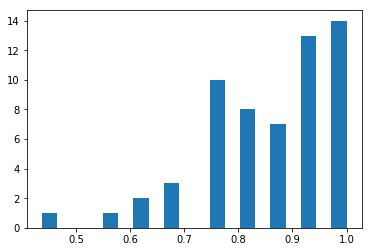

In [22]:
plt.hist(total_acc, bins=20)

In [23]:
print("Total Accuracy mean {}".format(total_acc.mean()))
print("Total Accuracy std {}".format(total_acc.std()))

Total Accuracy mean 0.8580508474576272
Total Accuracy std 0.12753287030313554


# Part 7. Layer-wise Relevance Propagation

In [ ]:
df = pd.read_csv(os.path.join(result_path, dataframe_filename))
df.head()

In [24]:
import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis

In [25]:
def LRP(model, df, train_index, test_index, selection_index_LRP, transpose_index=[3,2,1,0], result_path='./results'):
    
    #Loading data
    train_X, train_y, test_X, test_y, fmri_shape = load_dat(df, train_index, test_index, transpose_index)
    test_images = list(zip(test_X, test_y))

    # Create model without training softmax
    model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)
    
    for selection_index in selection_index_LRP:
        # Configure analysis methods and properties
        if selection_index == None:
            method = ("lrp.epsilon",    {"epsilon": 1,"neuron_selection_mode":"max_activation"},    ivis.heatmap,    "LRP-Epsilon")
        else:    
            method = ("lrp.epsilon",    {"epsilon": 1, "neuron_selection_mode" : "index"},    ivis.heatmap,     "LRP-Epsilon")

        # Create analyzer.
        analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                                model_wo_softmax, # model without softmax output
                                                **method[1])      # optional analysis parameters
        
        #Set names and path for saving
        model_name = df['model_weight'][test_index].unique()[0]
        lrp_index = 'lrp_index_'+str(selection_index)
        lrp_result_path = os.path.join(result_path, model_name, lrp_index)
        lrp_index_colum = lrp_index + '_path'
        
        #Making folders
        if not os.path.exists(lrp_result_path):
            os.makedirs(lrp_result_path)

        #Analyzing LRP
        for p, (x, y) in enumerate(test_images):
            
            # Add batch axis.
            x = x[None, :, :, :]
            
            # Analyze
            if selection_index == None:
                a = analyzer.analyze(x)
            else:
                a = analyzer.analyze(x, neuron_selection=selection_index)
                
            # Remove batch axis    
            a = a.squeeze() 
                
            lrp_file_name = df.iloc[test_index[p]]['type'] + '{:02d}'.format(p+1) + '.npy'
            lrp_file_path = os.path.join(lrp_result_path, lrp_file_name)
            
            #Saving LRP results image
            np.save(lrp_file_path, a)
            df[lrp_index_colum][test_index[p]] = os.path.abspath(lrp_file_path)

        print('{} of {} is saved'.format(lrp_index, model_name))

    return df

For LRP, you can select ouput node. `'None'` means **max_activation** node and you can use specific node number like `0` or `1`

In [34]:
selection_index_LRP=[0,1,None]

for i in selection_index_LRP:
    colum_name = 'lrp_index_' + str(i)+'_path'
    df[colum_name] = None

In [35]:
#Setting dataframe saving directory
df_csv_path = os.path.join(result_path, dataframe_filename)

#Loading CNN model graph without weight
from keras.models import model_from_json 
model_file = os.path.join(result_path, ('model_without_weight' + '.json'))
json_file = open(model_file, "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

LRP start!

In [37]:
for i, (train_index, test_index) in enumerate(logo.split(X=df['data_path'], y=df['type_onehot'], groups=df['subject'])):

    #Loading trained CNN model weight
    model_weight_path = df['model_path'][test_index].unique()[0]
    loaded_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    print("\n{} is loaded".format(model_weight_path))
    
    #LRP
    df = LRP(loaded_model, df, train_index, test_index, selection_index_LRP, transpose_index=[3,2,1,0], result_path=result_path)
    
    #Saving result data matrix
    df.to_csv(df_csv_path)


/home/cocoan-gpu1/Documents/Deep_Rejection/scripts/results_test_last/model_01/model_01_weight.h5 is loaded
lrp_index_0 of model_01 is saved
lrp_index_1 of model_01 is saved
lrp_index_None of model_01 is saved

/home/cocoan-gpu1/Documents/Deep_Rejection/scripts/results_test_last/model_02/model_02_weight.h5 is loaded
lrp_index_0 of model_02 is saved
lrp_index_1 of model_02 is saved
lrp_index_None of model_02 is saved

/home/cocoan-gpu1/Documents/Deep_Rejection/scripts/results_test_last/model_03/model_03_weight.h5 is loaded
lrp_index_0 of model_03 is saved
lrp_index_1 of model_03 is saved
lrp_index_None of model_03 is saved

/home/cocoan-gpu1/Documents/Deep_Rejection/scripts/results_test_last/model_04/model_04_weight.h5 is loaded
lrp_index_0 of model_04 is saved
lrp_index_1 of model_04 is saved
lrp_index_None of model_04 is saved

/home/cocoan-gpu1/Documents/Deep_Rejection/scripts/results_test_last/model_05/model_05_weight.h5 is loaded
lrp_index_0 of model_05 is saved
lrp_index_1 of mode

# Part 8. Visualization

Now you have lots of images resulting from LRP, which are same in number as all input data.

You can visualize mean of predicted type.

In [38]:
df = pd.read_csv(os.path.join(result_path, dataframe_filename))
df.head()

,Unnamed: 0,Unnamed: 0.1,index,data_path,type,type_onehot,subject,predicted_type_onehot,model_weight,model_path,model_acc,model_loss,lrp_index_0_path,lrp_index_1_path,lrp_index_None_path
0,0,0,0,/home/cocoan-gpu1/Documents/Deep_Rejection/dat...,heat,1,sub_01,1,model_01,/home/cocoan-gpu1/Documents/Deep_Rejection/scr...,1.0,0.042947,/home/cocoan-gpu1/Documents/Deep_Rejection/scr...,/home/cocoan-gpu1/Documents/Deep_Rejection/scr...,/home/cocoan-gpu1/Documents/Deep_Rejection/scr...
1,1,1,1,/home/cocoan-gpu1/Documents/Deep_Rejection/dat...,heat,1,sub_01,1,model_01,/home/cocoan-gpu1/Documents/Deep_Rejection/scr...,1.0,0.042947,/home/cocoan-gpu1/Documents/Deep_Rejection/scr...,/home/cocoan-gpu1/Documents/Deep_Rejection/scr...,/home/cocoan-gpu1/Documents/Deep_Rejection/scr...
2,2,2,2,/home/cocoan-gpu1/Documents/Deep_Rejection/dat...,heat,1,sub_01,1,model_01,/home/cocoan-gpu1/Documents/Deep_Rejection/scr...,1.0,0.042947,/home/cocoan-gpu1/Documents/Deep_Rejection/scr...,/home/cocoan-gpu1/Documents/Deep_Rejection/scr...,/home/cocoan-gpu1/Documents/Deep_Rejection/scr...
3,3,3,3,/home/cocoan-gpu1/Documents/Deep_Rejection/dat...,heat,1,sub_01,1,model_01,/home/cocoan-gpu1/Documents/Deep_Rejection/scr...,1.0,0.042947,/home/cocoan-gpu1/Documents/Deep_Rejection/scr...,/home/cocoan-gpu1/Documents/Deep_Rejection/scr...,/home/cocoan-gpu1/Documents/Deep_Rejection/scr...
4,4,4,4,/home/cocoan-gpu1/Documents/Deep_Rejection/dat...,heat,1,sub_01,1,model_01,/home/cocoan-gpu1/Documents/Deep_Rejection/scr...,1.0,0.042947,/home/cocoan-gpu1/Documents/Deep_Rejection/scr...,/home/cocoan-gpu1/Documents/Deep_Rejection/scr...,/home/cocoan-gpu1/Documents/Deep_Rejection/scr...


In [39]:
transpose_index = [3,2,1,0]

In [40]:
#Count number of predicted type
heat_count = df['predicted_type_onehot'][df['predicted_type_onehot']==1].count()
rejection_count = df['predicted_type_onehot'][df['predicted_type_onehot']==0].count()

You can chose what index result will visualize in this case we will visualize `'lrp_index_None_path'` or you can chose another index like `'lrp_index_0_path`, `'lrp_index_1_path'`

In [41]:
visualize_index = df['lrp_index_None_path']

In [42]:
#Preallocation
img_x, img_y, img_z = np.load(visualize_index[0]).shape
heat_lrp = np.ones((heat_count, img_x, img_y, img_z))
rejection_lrp = np.ones((rejection_count, img_x, img_y, img_z))

In [43]:
#Loading LRP images
heat_count = 0
rejection_count = 0

for i in range(len(df)):
    if df['predicted_type_onehot'][i] == 1:
        heat_lrp[heat_count] = np.load(visualize_index[i])
        heat_count += 1
        
    elif df['predicted_type_onehot'][i] == 0:
        rejection_lrp[rejection_count] = np.load(visualize_index[i])
        rejection_count += 1
        
rejection_lrp = rejection_lrp.transpose(transpose_index)
heat_lrp = heat_lrp.transpose(transpose_index)

In order to make nibabel object, you need to have base Nifti file's affine matrix and header

Details in [Nibabel images](https://nipy.org/nibabel/nibabel_images.html)

In [44]:
temp_nii = image.load_img(df.iloc[0]['data_path'])

import nibabel as nib
rejection_lrp_nib = nib.Nifti1Image(rejection_lrp, temp_nii.affine, temp_nii.header)
heat_lrp_nib = nib.Nifti1Image(heat_lrp, temp_nii.affine, temp_nii.header)

For plotting results, we are using `nilearn.plotting`

Details in [Plotting brain images](http://nilearn.github.io/plotting/index.html)

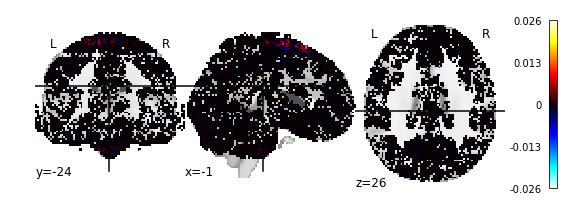

In [45]:
#Checking image
plotting.plot_stat_map(rejection_lrp_nib.slicer[:,:,:,25])

In [46]:
#Averaging images through predicted type
heat_lrp_mean = heat_lrp.mean(axis=-1)
heat_lrp_mean_nib = nib.Nifti1Image(heat_lrp_mean, temp_nii.affine, temp_nii.header)

rejection_lrp_mean = rejection_lrp.mean(axis=-1)
rejection_lrp_mean_nib = nib.Nifti1Image(rejection_lrp_mean, temp_nii.affine, temp_nii.header)

In [47]:
plotting.view_img(rejection_lrp_mean_nib, threshold=0.00005, cut_coords=[36, -24, 22],title='rejection_lrp_mean')

In [48]:
plotting.view_img(heat_lrp_mean_nib, threshold=0.00005, cut_coords=[36, -24, 22],title='heat_lrp_mean')

In [49]:
#Smoothing
reject_fwhm_4 = image.smooth_img(rejection_lrp_mean_nib, fwhm=4)
reject_fwhm_8 = image.smooth_img(rejection_lrp_mean_nib, fwhm=8)

heat_fwhm_4 = image.smooth_img(heat_lrp_mean_nib, fwhm=4)
heat_fwhm_8 = image.smooth_img(heat_lrp_mean_nib, fwhm=8)

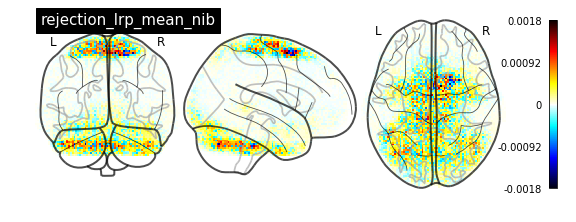

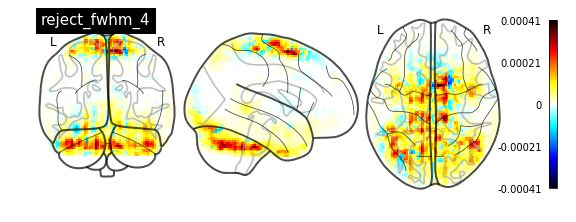

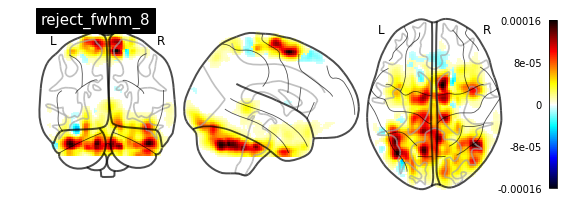

In [50]:
#Plotting glass brain
plotting.plot_glass_brain(rejection_lrp_mean_nib, cut_coords=[36, -24, 22], title='rejection_lrp_mean_nib', colorbar=True, plot_abs=False)
plotting.plot_glass_brain(reject_fwhm_4, cut_coords=[36, -24, 22], title='reject_fwhm_4', colorbar=True, plot_abs=False)
plotting.plot_glass_brain(reject_fwhm_8, cut_coords=[36, -24, 22], title='reject_fwhm_8', colorbar=True, plot_abs=False)

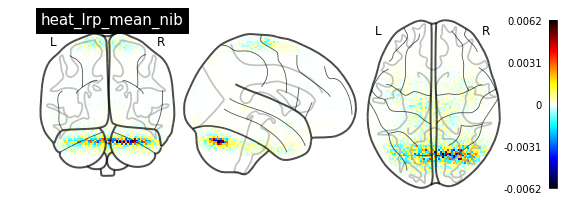

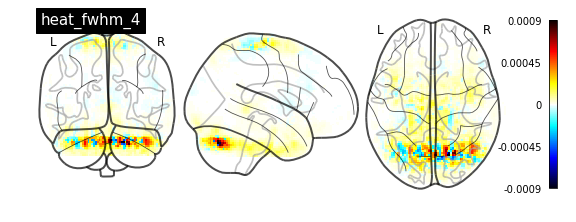

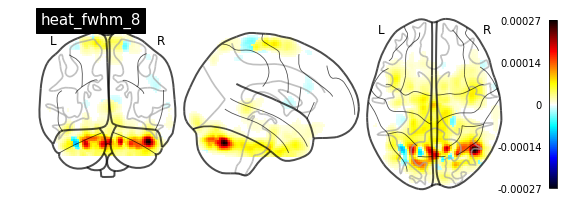

In [51]:
plotting.plot_glass_brain(heat_lrp_mean_nib, cut_coords=[36, -24, 22], title='heat_lrp_mean_nib', colorbar=True, plot_abs=False)
plotting.plot_glass_brain(heat_fwhm_4, cut_coords=[36, -24, 22], title='heat_fwhm_4', colorbar=True, plot_abs=False)
plotting.plot_glass_brain(heat_fwhm_8, cut_coords=[36, -24, 22], title='heat_fwhm_8', colorbar=True, plot_abs=False)

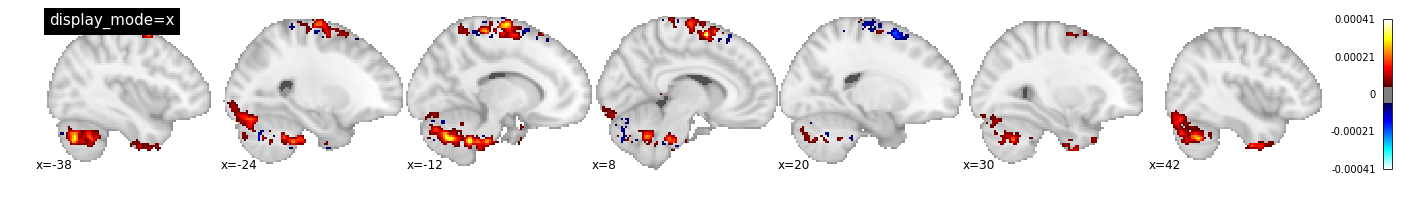

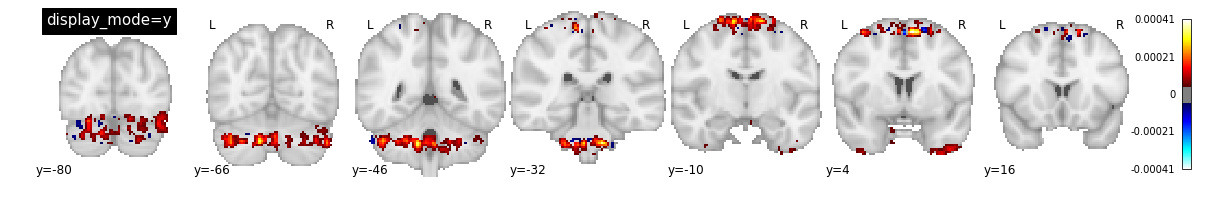

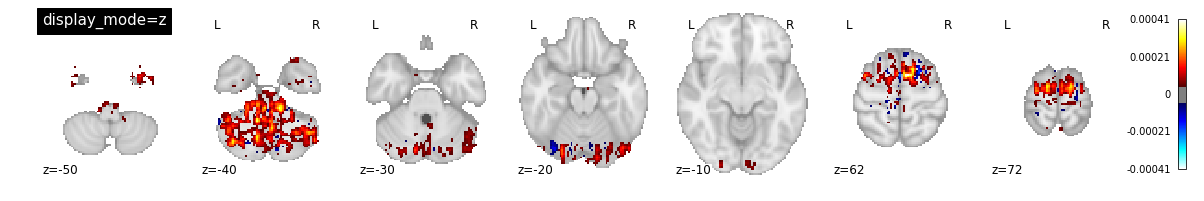

In [52]:
#Plotting stat map
plotting.plot_stat_map(reject_fwhm_4, threshold=0.00005, display_mode='x', cut_coords=7, title='display_mode=x')
plotting.plot_stat_map(reject_fwhm_4, threshold=0.00005, display_mode='y', cut_coords=7, title='display_mode=y')
plotting.plot_stat_map(reject_fwhm_4, threshold=0.00005, display_mode='z', cut_coords=7, title='display_mode=z')

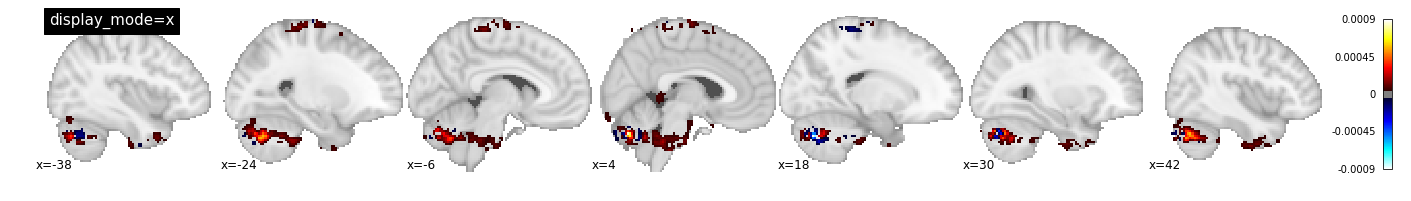

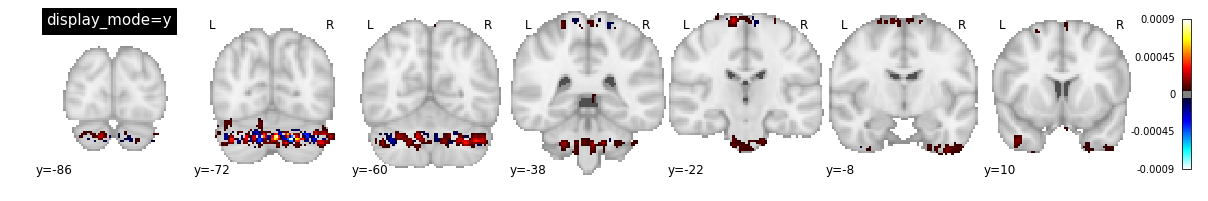

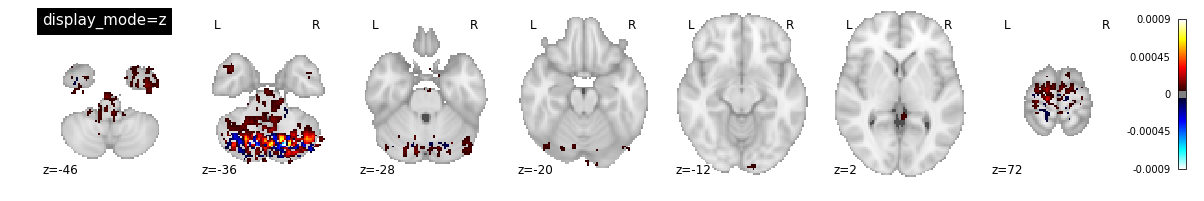

In [53]:
plotting.plot_stat_map(heat_fwhm_4, threshold=0.00005, display_mode='x', cut_coords=7, title='display_mode=x')
plotting.plot_stat_map(heat_fwhm_4, threshold=0.00005, display_mode='y', cut_coords=7, title='display_mode=y')
plotting.plot_stat_map(heat_fwhm_4, threshold=0.00005, display_mode='z', cut_coords=7, title='display_mode=z')

In [54]:
#plotting surface stat map
from nilearn import datasets, surface

fsaverage = datasets.fetch_surf_fsaverage()

reject_right = surface.vol_to_surf(reject_fwhm_4, fsaverage.pial_right)
reject_left = surface.vol_to_surf(reject_fwhm_4, fsaverage.pial_left)

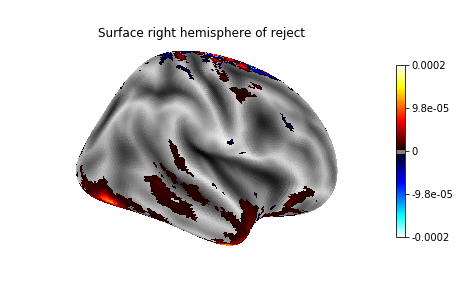

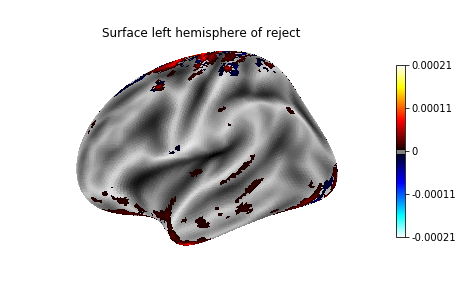

In [55]:
plotting.plot_surf_stat_map(fsaverage.infl_right, reject_right, hemi='right',
                            title='Surface right hemisphere of reject', colorbar=True,
                            threshold=0.000005, bg_map=fsaverage.sulc_right)
plotting.plot_surf_stat_map(fsaverage.infl_left, reject_left, hemi='left',
                            title='Surface left hemisphere of reject', colorbar=True,
                            threshold=0.000005, bg_map=fsaverage.sulc_left)
plotting.show()

In [56]:
heat_right = surface.vol_to_surf(heat_fwhm_4, fsaverage.pial_right)
heat_left = surface.vol_to_surf(heat_fwhm_4, fsaverage.pial_left)

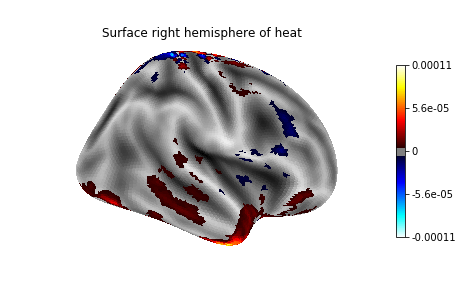

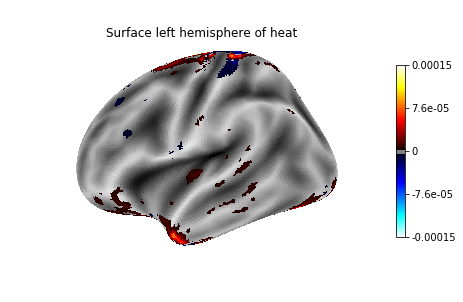

In [57]:
plotting.plot_surf_stat_map(fsaverage.infl_right, heat_right, hemi='right',
                            title='Surface right hemisphere of heat', colorbar=True,
                            threshold=0.000005, bg_map=fsaverage.sulc_right)
plotting.plot_surf_stat_map(fsaverage.infl_left, heat_left, hemi='left',
                            title='Surface left hemisphere of heat', colorbar=True,
                            threshold=0.000005, bg_map=fsaverage.sulc_left)
plotting.show()